In [1]:
import os
import sys
import math
import itertools
import json
import glob
from datetime import datetime
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from data_handling import (
    load_measurements_npz,
    load_state_npz,
    MeasurementDataset,
    MeasurementLoader
)

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Dict, Any


class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.normal_(self.W, std=0.01)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    # ==========================================================
    #  Symmetrized scoring (collapsed)
    # ==========================================================
    def _free_energies_pair(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor):
        """
        Unsymmetrized free energies F(v) and F(1-v) (0/1 visibles).
          F(v)   = -v^T b - sum_j softplus((vW)_j + c_j)
          F(1-v) computed via W_sum - vW trick.
        """
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_f = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_f).sum(dim=-1)

        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        F_v = term1_v - term2_v
        F_f = term1_f - term2_f
        return F_v, F_f

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        """
        Symmetrized free energy:
          F_sym(v) = -T log( exp(-F(v)/T) + exp(-F(1-v)/T) )
        """
        F_v, F_f = self._free_energies_pair(v, b_mod, c_mod)
        stacked = torch.stack([-F_v, -F_f], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    # ==========================================================
    #  Conditioning
    # ==========================================================
    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    # ==========================================================
    #  Vanilla Gibbs primitives
    # ==========================================================
    def _sample_h_given_v(self, v_eff: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        p_h = torch.sigmoid((v_eff @ self.W + c_mod) / self.T)
        return torch.bernoulli(p_h, generator=rng)

    def _sample_v_given_h(self, a: torch.Tensor, b_mod: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        # a := W h is passed in to reuse it across steps
        p_v = torch.sigmoid((a + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    @staticmethod
    def _apply_flip(v: torch.Tensor, s0: torch.Tensor) -> torch.Tensor:
        """
        s0 in {0,1} with shape (B,1):
          s0=1 -> keep v
          s0=0 -> flip v -> 1-v
        """
        return s0 * v + (1.0 - s0) * (1.0 - v)

    # ==========================================================
    #  Fast exact s-update using reused variables
    # ==========================================================
    def _sample_s_given_v_h(
            self,
            v: torch.Tensor,
            a: torch.Tensor,
            b_mod: torch.Tensor,
            rng: torch.Generator
    ) -> torch.Tensor:
        """
        Sample s0 (where s0=1 means s=0 / no flip) from p(s | v,h),
        using only joint-energy differences and reusing a := W h.

        dE = E(1-v, h) - E(v, h)
           = -(sum b) -(sum a) + 2(v·b) + 2(v·a)

        p(s0=1 | v,h) = sigmoid(dE / T).
        """
        vb   = (v * b_mod).sum(dim=-1)   # (B,)
        va   = (v * a).sum(dim=-1)       # (B,)
        bsum = b_mod.sum(dim=-1)         # (B,)
        asum = a.sum(dim=-1)             # (B,)

        dE = (-bsum - asum + 2.0 * vb + 2.0 * va)  # (B,)
        p_s0 = torch.sigmoid(dE / self.T)
        return torch.bernoulli(p_s0, generator=rng).to(v.dtype).unsqueeze(-1)

    # ==========================================================
    #  Symmetrized Gibbs step (uncollapsed; exact; no FE in loop)
    # ==========================================================
    def _gibbs_step_sym_fast(
            self,
            v: torch.Tensor,
            h: torch.Tensor,
            s0: torch.Tensor,
            b_mod: torch.Tensor,
            c_mod: torch.Tensor,
            rng: torch.Generator
    ):
        """
        Exact Gibbs on the augmented joint p(v,h,s) ∝ exp(-E(v^(s),h)/T)
        without evaluating free energies inside the loop.

        Procedurally:
          (1) h | v,s   using v_eff = v^(s)
          (2) s | v,h   using a = W h (reused)
          (3) v | h,s   sample v_eff, then map back (unflip if needed)
        """
        if rng is None:
            raise ValueError("aux_vars['rng'] must be provided for reproducible Bernoulli sampling.")

        v = v.to(dtype=self.W.dtype, device=self.W.device)

        # Ensure batch-shaped biases
        if b_mod.dim() == 1:
            b_mod = b_mod.unsqueeze(0).expand(v.size(0), -1)
        if c_mod.dim() == 1:
            c_mod = c_mod.unsqueeze(0).expand(v.size(0), -1)

        # (1) sample h | v,s (standard RBM update on effective visible)
        v_eff = self._apply_flip(v, s0)
        h = self._sample_h_given_v(v_eff, c_mod, rng)

        # Precompute a = W h once (reused in s-update and v-update)
        a = h @ self.W.t()  # (B, V)

        # (2) sample s | v,h (cheap; reuses a)
        s0 = self._sample_s_given_v_h(v, a, b_mod, rng)

        # (3) sample v | h,s (standard RBM visible update in effective space)
        v_eff = self._sample_v_given_h(a, b_mod, rng)
        v_next = self._apply_flip(v_eff, s0)

        return v_next, h, s0

    # ==========================================================
    #  Scoring + training
    # ==========================================================
    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)
        rng = aux_vars.get("rng")

        b_mod, c_mod = self._compute_effective_biases(cond)
        v_model = v_data.clone()

        n_noise = int(v_data.shape[0] * aux_vars.get("noise_frac", 0.1))
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(
                torch.full_like(v_model[:n_noise], 0.5),
                generator=rng
            )

        # Initialize chain state (s and h)
        B = v_model.size(0)
        s0 = torch.bernoulli(
            torch.full((B, 1), 0.5, device=v_model.device, dtype=v_model.dtype),
            generator=rng
        )
        h = torch.zeros((B, self.num_hidden), device=v_model.device, dtype=v_model.dtype)

        for _ in range(self.k):
            v_model, h, s0 = self._gibbs_step_sym_fast(v_model, h, s0, b_mod, c_mod, rng)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = fe_data.mean() - fe_model.mean()
        return loss, {}

    @torch.no_grad()
    def get_normalized_wavefunction(self, cond: torch.Tensor, all_states: torch.Tensor) -> torch.Tensor:
        if cond.dim() == 1:
            cond = cond.unsqueeze(0)
        cond_exp = cond.expand(all_states.shape[0], -1)

        old_T = self.T
        self.T = 1.0  # we use T=1 for wavefunction extraction (not properly refactored yet)
        log_psi = self.log_score(all_states, cond_exp)
        self.T = old_T

        log_norm_sq = torch.logsumexp(2.0 * log_psi, dim=0)
        return torch.exp(log_psi - 0.5 * log_norm_sq)

In [3]:
def get_sigmoid_curve(high, low, steps, falloff):
    center = steps / 2.0
    def fn(step):
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center))))
    return fn

def train(model, optimizer, loader, num_epochs, rng, lr_schedule_fn):
    global_step = 0
    model.train()
    training_noise_frac = 0.1

    print(f"{'Epoch':<6} | {'Loss':<10} | {'LR':<10}")
    print("-" * 30)

    for epoch in range(num_epochs):
        tot_loss = 0.0
        for batch in loader:
            lr = lr_schedule_fn(global_step)
            for g in optimizer.param_groups: g["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            loss, _ = model(batch, {"rng": rng, "noise_frac": training_noise_frac})
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            global_step += 1

        if (epoch + 1) % 10 == 0:
            print(f"{epoch+1:<6} | {tot_loss/len(loader):+.4f}     | {lr:.6f}")

    return model

def generate_all_states(num_qubits: int, device: torch.device):
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true) # ensure GT is normalized (just to be safe)

    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [11]:
GEN_SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 5_000_000
TRAIN_SAMPLE_COUNT = 20_000
N_EPOCHS = 50

# load support and novel points (make sure they exist)
h_support = [1.00, 1.60, 2.00, 2.30, 2.80, 3.00, 4.00, 5.00]
h_novel   = [1.80, 2.50, 3.50]
all_h_values = sorted(list(set(h_support + h_novel)))

file_names = [f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

missing = [fp for fp in file_paths if not fp.exists()]
if missing:
    raise FileNotFoundError(f"Missing data files: {missing}. Please run generation first.")

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)


print(f"Training on {TRAIN_SAMPLE_COUNT} samples per point.")
print(f"Support points: {h_support}")

ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [TRAIN_SAMPLE_COUNT]*len(file_paths))
loader = MeasurementLoader(ds, batch_size=1024, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(ds.num_qubits, num_hidden=128, cond_dim=1, conditioner_width=64, k=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = get_sigmoid_curve(1e-2, 1e-4, N_EPOCHS*len(loader), 0.005)

print("\nStarting Training...")
model = train(model, optimizer, loader, N_EPOCHS, rng, scheduler)

# evaluate overlap with ground truth states
print("\nEvaluating Overlap...")
all_states = generate_all_states(GEN_SIDE_LENGTH**2, device)

results = []
for h_val in all_h_values:
    gt_path = state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h_val:.2f}.npz"
    if gt_path.exists():
        ov = compute_overlap(model, h_val, gt_path, all_states)
        rtype = "support" if h_val in h_support else "novel"
        results.append({"h": h_val, "overlap": ov, "type": rtype})
        print(f"h={h_val:.2f} ({rtype:7}) | Overlap = {ov:.5f}")

print("\nFinished.")

Training on 20000 samples per point.
Support points: [1.0, 1.6, 2.0, 2.3, 2.8, 3.0, 4.0, 5.0]

Starting Training...
Epoch  | Loss       | LR        
------------------------------
10     | +0.0072     | 0.010000
20     | +0.0044     | 0.009809
30     | -0.0107     | 0.000293
40     | -0.0144     | 0.000100
50     | -0.0070     | 0.000100

Evaluating Overlap...
h=1.00 (support) | Overlap = 0.99969
h=1.60 (support) | Overlap = 0.99916
h=1.80 (novel  ) | Overlap = 0.99877
h=2.00 (support) | Overlap = 0.99811
h=2.30 (support) | Overlap = 0.99566
h=2.50 (novel  ) | Overlap = 0.99245
h=2.80 (support) | Overlap = 0.98933
h=3.00 (support) | Overlap = 0.99133
h=3.50 (novel  ) | Overlap = 0.99666
h=4.00 (support) | Overlap = 0.99744
h=5.00 (support) | Overlap = 0.99805

Finished.


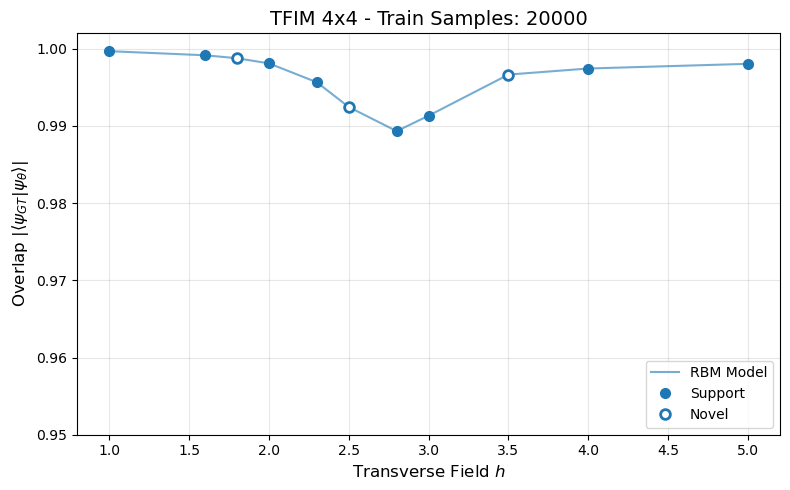

In [12]:
df = pd.DataFrame(results)
supp = df[df["type"] == "support"]
nov  = df[df["type"] == "novel"]

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(df["h"], df["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")
plt.plot(supp["h"], supp["overlap"], 'o', color='tab:blue', markersize=7, label="Support")
plt.plot(nov["h"], nov["overlap"], 'o', color='tab:blue', markerfacecolor='white', markeredgewidth=2, markersize=7, label="Novel")

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_{GT} | \psi_{\theta} \rangle|$", fontsize=12)
plt.title(f"TFIM 4x4 - Train Samples: {TRAIN_SAMPLE_COUNT}", fontsize=14)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"crbm_tfim_4x4_{TRAIN_SAMPLE_COUNT}_suscept_{timestamp}.pt"
save_path = models_dir / filename

save_dict = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "config": {
        "num_visible": model.num_visible,
        "num_hidden": model.num_hidden,
        "k_steps": model.k,
        "train_samples": TRAIN_SAMPLE_COUNT,
        "epochs": N_EPOCHS,
        "h_support": h_support
    },
    "results": results
}

torch.save(save_dict, save_path)
print(f"Model saved successfully to:\n{save_path.resolve()}")

Model saved successfully to:
/Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_polish/tfim_4x4_new/models/crbm_tfim_4x4_20000_suscept_20251215_210416.pt
